In [6]:
import numpy as np
import pystan
import pickle
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
model_code = """
data {
        int<lower=1> N; // Number of spectra
        int<lower=1> W; // Number of wavenumbers
        int<lower=1> K; // Number of components
        matrix[W,N] X;  // Data matrix, should be nonnegative
} parameters {
        vector<lower=0>[K] c;
        vector[K] eta;
        matrix[K,N] alpha;
        vector<lower=0>[K] gamma;
        vector<lower=0>[N] beta;
        vector<lower=0>[W] B;
        real<lower=0> tau; // Precision of normal observation model

} transformed parameters {
        matrix[W,K] V;
        matrix[W,N] I;
        // This assumes that wavenumber is equal to index...
        for (w in 1:W) {
            for (k in 1:K) {
                V[w,k] = eta[k] * gamma[k] * pi()^(-1) / ((w-c[k])^2 + gamma[k]^2)
                + (1-eta[k]) * 1.0 / (sqrt(2*pi())*gamma[k]) * exp(-(w-c[k])^2 / (2*gamma[k]^2));
            }
        }
        
        for (w in 1:W) {
            for (n in 1:N) {
                I[w,n] = dot_product(alpha[:,n], V[w,:]') + beta[n]*B[w];
            }
        }
        
}
model {
        // priors - hyper priors are from original implementation
        eta ~ uniform(0,1);
        
        for (k in 1:K) {
            for (n in 1:N) {
                // notice that in original implementation A=alpha and alpha=alpha_0
                alpha[k,n] ~ exponential(5);
            }
        }
    
        for (k in 1:K) {
            c[k]  ~ normal(5, 0.1) T[0, ];
            gamma[k] ~ normal(10, 1) T[0, ]; 
        }
        
        tau ~ gamma(W * N / 2.0 + 0, 0.5 * sum(((X-I) .* (X-I))));
        //tau ~ gamma(1,1);
        for (n in 1:N) {
            beta[n] ~ normal(0.5, 0.001) T[0, ];
        }
        for (w in 1:W) {
             B[w] ~ normal(0.5, 0.01) T[0, ];
        }
        for (w in 1:W) {
            for (n in 1:N) {
                X[w,n] ~ normal(I[w,n], 1.0 / tau);
            }
        }

}
"""

In [8]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4534d740ffd0643022251cab341d92e7 NOW.


In [9]:
simulated = loadmat('simulated.mat')
X = simulated['X']
print(X.shape) # 625 x 300 = (25*25) x 300, ie. N = 625, W = 300, and thus the Raman map is 25 x 25.


(625, 300)


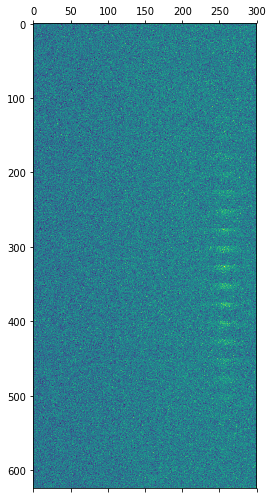

In [10]:
plt.matshow(X);
plt.show()

In [11]:
#X = np.random.exponential(100,size=(10,10))
print(X)
N, W = X.shape
X_in = X.T
K = 2
data = {'X' : X_in, 'N' : N, 'W' : W, 'K' : K}

[[ 2.04532901 -1.02532289 -1.01969499 ... -0.59737262  0.56980519
   0.27390275]
 [ 1.4505098   0.27916059  2.54280303 ...  0.06195588  2.17910471
   1.42659167]
 [ 1.23121317  2.63978801 -0.34891624 ... -0.76048608  0.68798659
   0.81538005]
 ...
 [ 2.18007623  1.76319414  1.86998041 ...  3.23938053 -0.95502932
   1.61173183]
 [ 2.42579365  3.05755773  0.9858123  ...  0.75274917 -0.35923882
   0.19887759]
 [ 0.91652058  0.43266895  1.14265622 ...  2.04732277  1.77402445
   0.3738705 ]]


In [ ]:
fit = sm.sampling(data, iter=10000, chains=1, verbose=True, pars=['B','beta','tau','gamma','c','alpha','eta'], init=[{'alpha' : 0.1*np.ones((K,N))}])